<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания по заказу такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

Импортируем необходимые библиотеки и инструменты для работы с данными.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Сохраним файл в переменную df. Нулевой столбец распознаем как даты и укажем в качестве индекса.

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Отсортируем индексы по возрастанию.

In [3]:
df = df.sort_index()

Взглянем напервые пять строк таблицы.

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Рассмотрим основную информацию о таблице.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, что индекс монотонный.

In [6]:
df.index.is_monotonic

True

Выполним ресэмплирование данных по одному часу.

In [7]:
df = df.resample('1H').sum()

## Анализ

Разложим данные на тренд, сезонность и остаток.

In [8]:
decomposed = seasonal_decompose(df)

Построим график тренда.

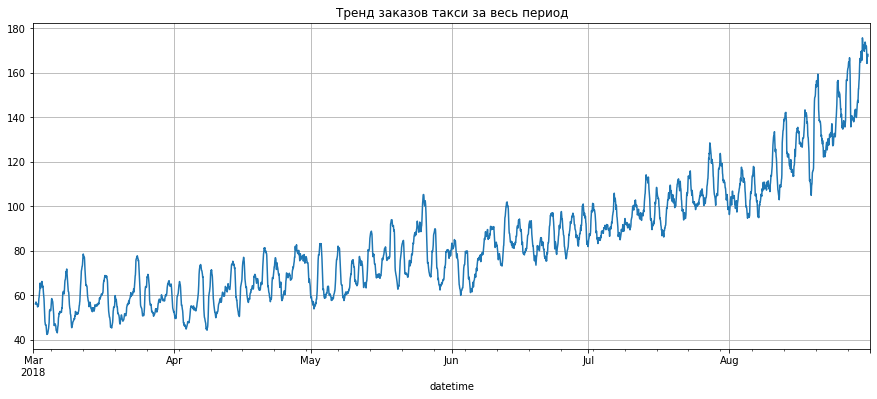

In [9]:
decomposed.trend.plot(figsize=(15,6), grid=True, title='Тренд заказов такси за весь период')
plt.show()

Наблюдается тренд на увеличение количества заказов такси.

Теперь рассмотрим сезонную составляющую.

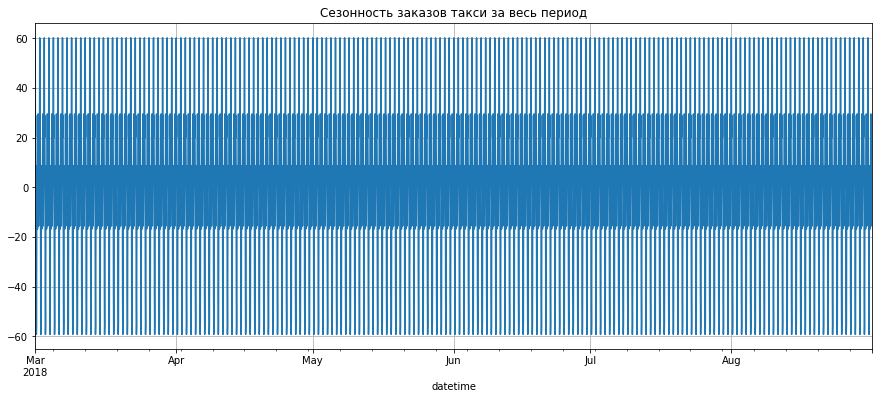

In [10]:
decomposed.seasonal.plot(figsize=(15,6), grid=True, title='Сезонность заказов такси за весь период')
plt.show()

График неинформативен, слишком много данных. Попробуем взять данные за 1 месяц. Рассмотрим первый и последний месяц выборки.

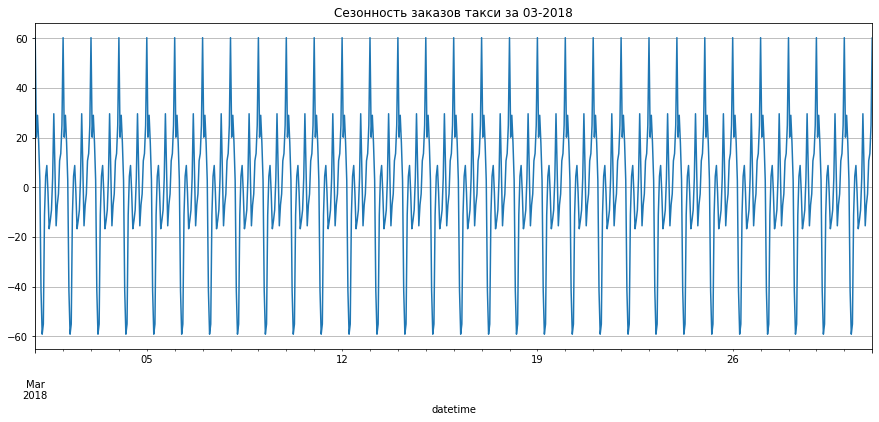

In [11]:
decomposed.seasonal.plot(figsize=(15,6), grid=True, title='Сезонность заказов такси за 03-2018')
plt.xlim('2018-03-01', '2018-03-31')
plt.show()

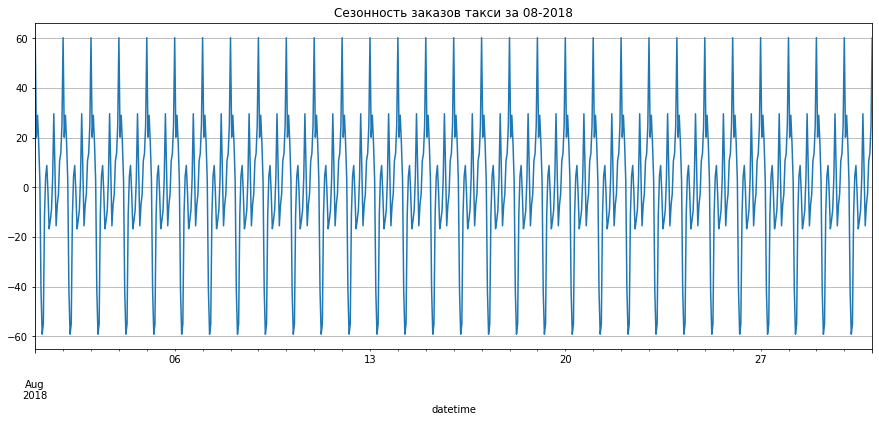

In [12]:
decomposed.seasonal.plot(figsize=(15,6), grid=True, title='Сезонность заказов такси за 08-2018')
plt.xlim('2018-08-01', '2018-08-31')
plt.show()

В обоих случаях наблюдается цикличный процесс. Каждый день распределение количества заказов такси происходит одинаково.

Также построим график за 2 суток, чтобы узнать распределение заказов по часам.

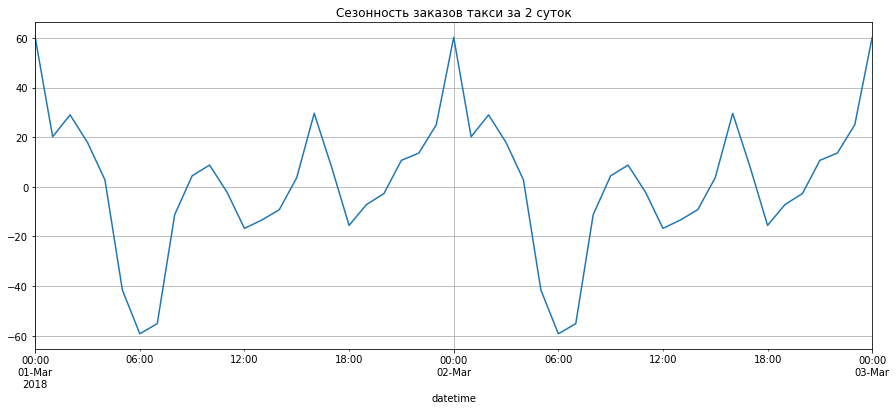

In [13]:
decomposed.seasonal.plot(figsize=(15,6), grid=True, title='Сезонность заказов такси за 2 суток')
plt.xlim('2018-03-01', '2018-03-03')
plt.show()

Пиковая нагрузка наблюдается в 00:00 часов. Далее идет постепенный спад до 06:00 часов, в 06:00 количество заказов минимально. Затем количество заказов постепенно увеличивается с двумя пиками в районе 10:00 и 16:00 часов.

Добавим в данные скользящее среднее с размером окна 12 часов (половина одних суток) и 24 часа (полные сутки).

In [14]:
df['rolling_12_hours'] = df['num_orders'].shift(1).rolling(12).mean()
df['rolling_24_hours'] = df['num_orders'].shift(1).rolling(24).mean()

Построим график за 1 месяц, возьмем также первый и последний месяц выборки.

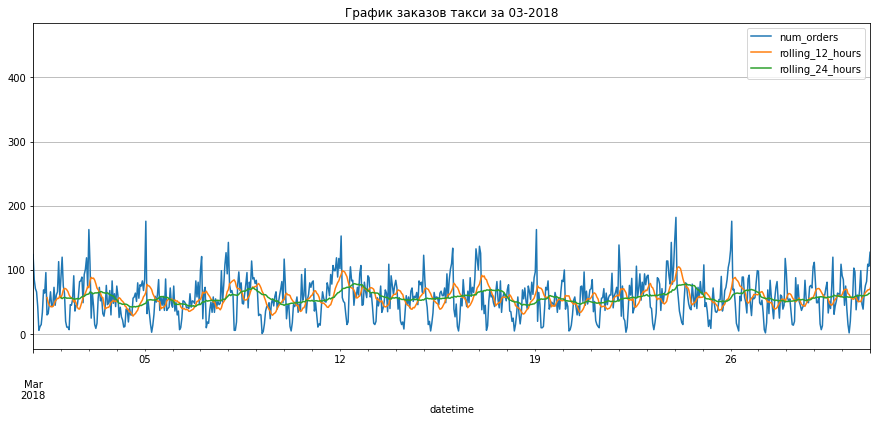

In [15]:
df.plot(figsize=(15,6), grid=True, title='График заказов такси за 03-2018')
plt.xlim('2018-03-01', '2018-03-31')
plt.show()

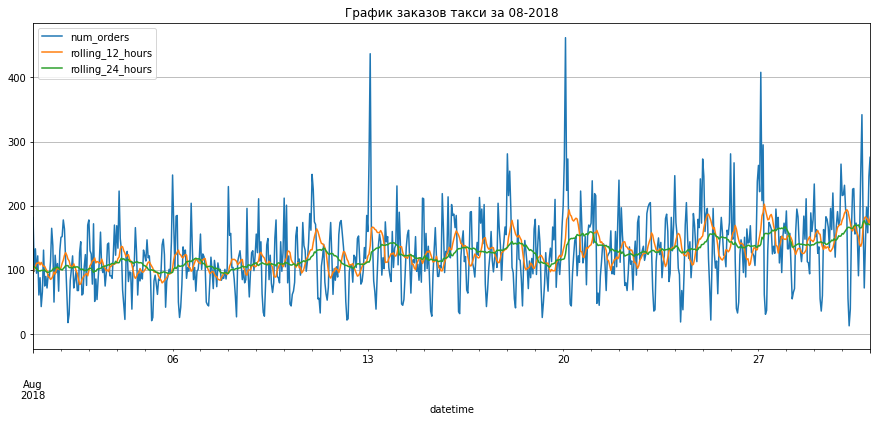

In [16]:
df.plot(figsize=(15,6), grid=True, title='График заказов такси за 08-2018')
plt.xlim('2018-08-01', '2018-08-31')
plt.show()

Скользящее среднее с размером окна 12 довольно точно отражает график общего количества заказов такси.

- По итогам анализа данных удалось выявить тренд на увеличение числа заказов в рамках рассматриваемого периода (что также может являться сезонным увеличением числа заказов в летние месяцы, однако утверждать это нельзя ввиду анализа данных только за полгода).
- Также выявлена сезонность заказов в течение дня: пиковая нагрузка приходится на 00:00 часов, минимальное число заказов - на 06:00 часов.
- Распределение количества заказов в течение дня не меняется в рамках рассматриваемого периода.
- Месячная сезонность не обнаружена.

## Обучение

**1. Подготовка данных**

Добавим в данные новые столбцы: час и день недели.

In [17]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

Также добавим столбцы с отстающими признаками - предыдущее значение, значения в тот же час в каждый день недели.

In [18]:
df['lag_1_hour'] = df['num_orders'].shift(1)
df['lag_1_day'] = df['num_orders'].shift(24)
df['lag_2_days'] = df['num_orders'].shift(24 * 2)
df['lag_3_days'] = df['num_orders'].shift(24 * 3)
df['lag_4_days'] = df['num_orders'].shift(24 * 4)
df['lag_5_days'] = df['num_orders'].shift(24 * 5)
df['lag_6_days'] = df['num_orders'].shift(24 * 6)
df['lag_7_days'] = df['num_orders'].shift(24 * 7)

Добавим также скользящее среднее с размером окна в 7 дней.

In [19]:
df['rolling_1_week'] = df['num_orders'].shift(1).rolling(24 * 7).mean()

Удалим строки с пропусками.

In [20]:
df = df.dropna()

Еще раз рассмотрим первые 5 строк таблицы с новыми признаками.

In [21]:
df.head()

,num_orders,rolling_12_hours,rolling_24_hours,hour,day_of_week,lag_1_hour,lag_1_day,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days,lag_7_days,rolling_1_week
datetime,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,69.250000,60.041667,0,3,94.0,100.0,42.0,86.0,75.0,163.0,90.0,124.0,54.226190
2018-03-08 01:00:00,78,78.333333,61.833333,1,3,143.0,121.0,75.0,176.0,60.0,108.0,120.0,85.0,54.339286
2018-03-08 02:00:00,65,80.250000,60.041667,2,3,78.0,24.0,36.0,32.0,26.0,25.0,75.0,71.0,54.297619
2018-03-08 03:00:00,68,82.083333,61.750000,3,3,65.0,66.0,49.0,51.0,42.0,64.0,64.0,66.0,54.261905
2018-03-08 04:00:00,60,83.500000,61.833333,4,3,68.0,73.0,30.0,34.0,27.0,44.0,20.0,43.0,54.273810


Разделим данные на обучающую и тестовую выборки.

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Выделим в каждой выборке признаки и целевой признак.

In [23]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Проверим корректность разделения временного ряда.

In [24]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


Для кросс-валидации временного ряда используем TimeSeriesSplit.

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

Сохраним целевое значение RMSE в отдельную переменную.

In [26]:
max_rmse = 48

Приступим к обучению моделей.

**2. Линейная регрессия**

In [27]:
%%time

model_lr = LinearRegression()
scores_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)
rmse_lr = scores_lr.mean() * -1

print('RMSE линейной регрессии:', rmse_lr)
if rmse_lr < max_rmse:
    print('RMSE ниже целевого уровня', '\n')
else:
    print('RMSE выше целевого уровня', '\n')

RMSE линейной регрессии: 22.75686144712442
RMSE ниже целевого уровня 

CPU times: user 59.7 ms, sys: 107 ms, total: 167 ms
Wall time: 149 ms


**3. Дерево решений**

In [28]:
%%time

params_dtr = {'max_depth': range(2, 7)}

model_dtr = DecisionTreeRegressor(random_state=12345)
gscv_dtr = GridSearchCV(model_dtr, params_dtr, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
gscv_dtr.fit(features_train, target_train)
rmse_dtr = -1 * gscv_dtr.best_score_

print('RMSE дерева решений:', rmse_dtr)
print('Лучшие гиперпараметры:', gscv_dtr.best_params_)
if rmse_dtr < max_rmse:
    print('RMSE ниже целевого уровня', '\n')
else:
    print('RMSE выше целевого уровня', '\n')

RMSE дерева решений: 26.944879438718683
Лучшие гиперпараметры: {'max_depth': 5}
RMSE ниже целевого уровня 

CPU times: user 219 ms, sys: 55.7 ms, total: 275 ms
Wall time: 347 ms


**4. Случайный лес**

In [29]:
%%time

params_rfr = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(2, 7)
}

model_rfr = RandomForestRegressor(random_state=12345)
gscv_rfr = GridSearchCV(model_rfr, params_rfr, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
gscv_rfr.fit(features_train, target_train)
rmse_rfr = -1 * gscv_rfr.best_score_

print('RMSE случайного леса:', rmse_rfr)
print('Лучшие гиперпараметры:', gscv_rfr.best_params_)
if rmse_rfr < max_rmse:
    print('RMSE ниже целевого уровня', '\n')
else:
    print('RMSE выше целевого уровня', '\n')

RMSE случайного леса: 23.53841371461573
Лучшие гиперпараметры: {'max_depth': 6, 'n_estimators': 70}
RMSE ниже целевого уровня 

CPU times: user 40.6 s, sys: 362 ms, total: 41 s
Wall time: 41.1 s


**5. Градиентный бустинг CatBoost**

In [30]:
%%time

model_cb = CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', iterations=100, random_state=12345)
scores_cb = cross_val_score(model_cb, features_train, target_train, fit_params={'verbose': False}, 
                            scoring='neg_root_mean_squared_error', cv=tscv)
rmse_cb = scores_cb.mean() * -1

print('RMSE градиентного бустинга CatBoost:', rmse_cb)
if rmse_cb < max_rmse:
    print('RMSE ниже целевого уровня', '\n')
else:
    print('RMSE выше целевого уровня', '\n')

RMSE градиентного бустинга CatBoost: 24.917487635093256
RMSE ниже целевого уровня 

CPU times: user 794 ms, sys: 40.2 ms, total: 834 ms
Wall time: 2.54 s


**6. Градиентный бустинг Light GBM**

In [31]:
%%time

model_lgbm = LGBMRegressor(metric='rmse', max_depth=7, random_state=12345)
scores_lgbm = cross_val_score(model_lgbm, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)
rmse_lgbm = scores_lgbm.mean() * -1

print('RMSE градиентного бустинга Light GBM:', rmse_lgbm)
if rmse_lgbm < max_rmse:
    print('RMSE ниже целевого уровня', '\n')
else:
    print('RMSE выше целевого уровня', '\n')

RMSE градиентного бустинга Light GBM: 24.40115660454714
RMSE ниже целевого уровня 

CPU times: user 5.74 s, sys: 61.6 ms, total: 5.8 s
Wall time: 5.8 s


## Тестирование

Сравним результаты всех моделей.

In [32]:
models = ['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'Градиентный бустинг CatBoost', 'Градиентный бустинг Light GBM']
columns = ['Место по скорости', 'RMSE', 'Место по RMSE', 'RMSE ниже 48']

results = pd.DataFrame([
    [1, rmse_lr, 1, 'да'], 
    [2, rmse_dtr, 5, 'да'], 
    [5, rmse_rfr, 2, 'да'], 
    [3, rmse_cb, 4, 'да'], 
    [4, rmse_lgbm, 3, 'да']
], index=models, columns=columns)

results

,Место по скорости,RMSE,Место по RMSE,RMSE ниже 48
Линейная регрессия,1,22.756861,1,да
Дерево решений,2,26.944879,5,да
Случайный лес,5,23.538414,2,да
Градиентный бустинг CatBoost,3,24.917488,4,да
Градиентный бустинг Light GBM,4,24.401157,3,да


Самый низкий RMSE и самая высокая скорость работы у линеной регрессии. Проверим ее качество на тестовой выборке.

RMSE линейной регрессии: 34.64711716714481
RMSE ниже целевого уровня


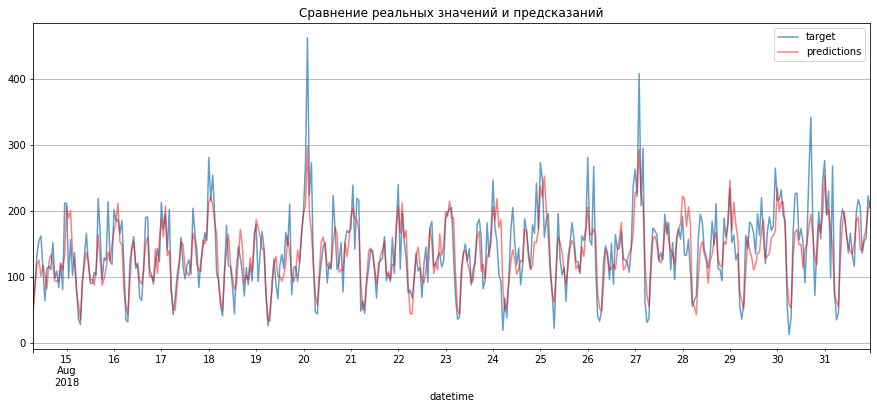

In [33]:
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_test)
rmse_lr_test = mean_squared_error(target_test, predictions_lr) ** 0.5

print('RMSE линейной регрессии:', rmse_lr_test)
if rmse_lr_test < max_rmse:
    print('RMSE ниже целевого уровня')
else:
    print('RMSE выше целевого уровня')
    
target_test.plot(figsize=(15, 6), grid=True, legend=True, label='target', alpha=0.7)
pd.Series(predictions_lr, index=target_test.index).plot(figsize=(15, 6), grid=True, legend=True, label='predictions', 
                                                        alpha=0.5, color='r')
plt.title('Сравнение реальных значений и предсказаний')
plt.show()

На тестовой выборке линейная регрессия также показала значение RMSE ниже заданного целевого уровня. Можно рекомендовать данную модель для прогнозирования количества заказов такси.